In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'No Shuffle', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['No Shuffle', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for No Shuffle data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# Shuffle DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# ------------------ TimeMoE Model ------------------

class Expert(nn.Module):
    def __init__(self, n_features, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class GatingNetwork(nn.Module):
    def __init__(self, n_features, n_experts):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, n_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class TimeMoE(nn.Module):
    def __init__(self, n_features, d_model=64, n_experts=4):
        super().__init__()
        self.experts = nn.ModuleList([Expert(n_features, d_model) for _ in range(n_experts)])
        self.gate = GatingNetwork(n_features, n_experts)
        self.final = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size, seq_len, n_features = x.shape
        x_flat = x[:, -1, :]  # Use last timestep for gating
        gate_weights = self.gate(x_flat)

        expert_outputs = torch.stack([expert(x_flat) for expert in self.experts], dim=1)
        gated_output = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs, dim=1)

        out = self.final(gated_output)
        return out.squeeze()

In [10]:
# ------------------ Dataset Preparation ------------------

def create_autoregressive_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [19]:
def evaluate_two_timemoe_models(
    model_orig, model_aug, scaler, X_test, y_test, y_train_org, features, seq_len, 
    time_index=None, start_point=0, end_point=None
):
    # Subset test data before scaling
    X_test_sub = X_test.iloc[start_point:end_point].reset_index(drop=True)
    y_test_sub = y_test.iloc[start_point:end_point].reset_index(drop=True)

    # Scale only subset
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_sub), columns=features)
    X_seq, y_seq = create_autoregressive_sequences(X_test_scaled, y_test_sub, seq_len)

    # Convert to tensor for model
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # Get predictions for Shuffle model
    model_orig.eval()
    with torch.no_grad():
        preds_orig = model_orig(X_tensor).numpy()

    # Get predictions for No Shuffle model
    model_aug.eval()
    with torch.no_grad():
        preds_aug = model_aug(X_tensor).numpy()

    # Inverse scaling target using Shuffle train target
    y_scaler = StandardScaler()
    y_scaler.fit(y_train_org.values.reshape(-1, 1))

    y_seq_inv = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
    preds_orig_inv = y_scaler.inverse_transform(preds_orig.reshape(-1, 1)).flatten()
    preds_aug_inv = y_scaler.inverse_transform(preds_aug.reshape(-1, 1)).flatten()

    # Metrics for Shuffle model
    mse_orig = mean_squared_error(y_seq_inv, preds_orig_inv)
    mae_orig = mean_absolute_error(y_seq_inv, preds_orig_inv)
    rmse_orig = math.sqrt(mse_orig)

    # Metrics for No Shuffle model
    mse_aug = mean_squared_error(y_seq_inv, preds_aug_inv)
    mae_aug = mean_absolute_error(y_seq_inv, preds_aug_inv)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Shuffle Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"No Shuffle Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # Prepare time index for plotting
    if time_index is not None:
        plot_range = time_index[start_point + seq_len : end_point]
    else:
        plot_range = range(len(y_seq_inv))

    plt.figure(figsize=(16, 6))
    
    # Plot actual
    plt.plot(plot_range, y_seq_inv, label='Actual', color='black')
    
    # Plot forecasts
    plt.plot(plot_range, preds_orig_inv, label='Shuffle Model Forecast', color='red', linestyle='--')
    plt.plot(plot_range, preds_aug_inv, label='No Shuffle Model Forecast', color='green', linestyle=':')

    # Shade between Actual and Shuffle Forecast (pink)
    plt.fill_between(plot_range, y_seq_inv, preds_orig_inv,
                     where=(y_seq_inv >= preds_orig_inv),
                     interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Shuffle)')
    plt.fill_between(plot_range, preds_orig_inv, y_seq_inv,
                     where=(y_seq_inv < preds_orig_inv),
                     interpolate=True, color='pink', alpha=0.5)

    # Shade between Shuffle Forecast and No Shuffle Forecast (light blue)
    plt.fill_between(plot_range, preds_orig_inv, preds_aug_inv,
                     where=(preds_aug_inv >= preds_orig_inv),
                     interpolate=True, color='lightblue', alpha=0.5, label='Difference (Shuffle - No Shuffle)')
    plt.fill_between(plot_range, preds_aug_inv, preds_orig_inv,
                     where=(preds_aug_inv < preds_orig_inv),
                     interpolate=True, color='lightblue', alpha=0.5)

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimeMoE Forecast Comparison: Shuffle vs No Shuffle")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Shuffle Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'No Shuffle Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()


In [20]:
seq_len = 24

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])
y_test = org_test_processed[target]

In [21]:
import joblib

In [22]:
model_TimeMOE_no_shuffle =TimeMoE(len(features))
# Load model state_dict
model_path  = "../Models/weights/TimeMOE_org_no_shuffle_model.pth"
model_TimeMOE_no_shuffle.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_TimeMOE_no_shuffle.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_TimeMOE_aug.pkl'
scaler_TimeMOE_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.


In [23]:
model_TimeMOE_org =TimeMoE(len(features))
# Load model state_dict
model_path  = "../Models/weights/TimeMOE_org_model.pth"
model_TimeMOE_org.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_TimeMOE_org.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/scaler_TimeMOE_org.pkl'
scaler_TimeMOE_org = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.



Evaluating PatchTST on test data...
Shuffle Model - MSE: 0.0000, MAE: 0.0019, RMSE: 0.0030
No Shuffle Model - MSE: 0.0000, MAE: 0.0039, RMSE: 0.0057


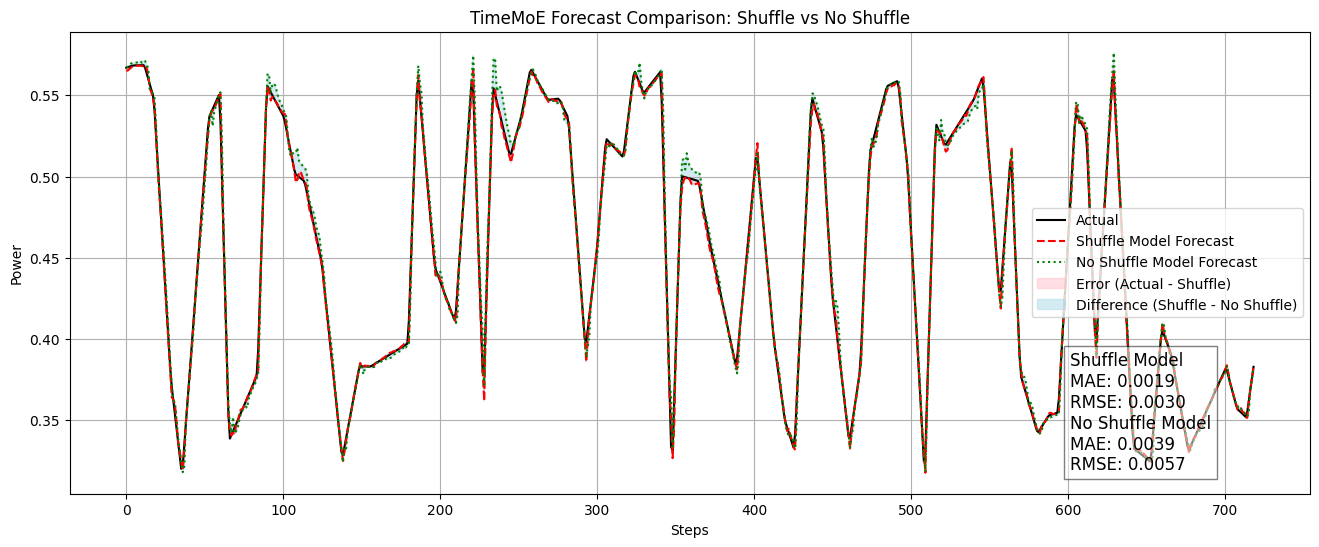

Shuffle Model - MSE: 0.0000, MAE: 0.0015, RMSE: 0.0025
No Shuffle Model - MSE: 0.0000, MAE: 0.0038, RMSE: 0.0058


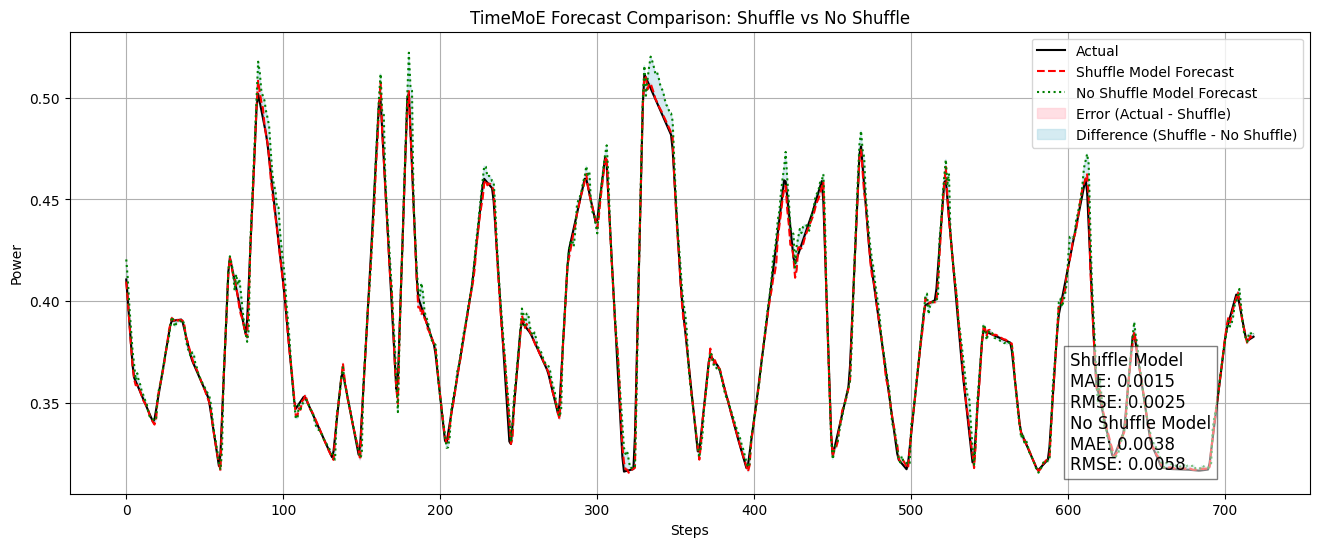

Shuffle Model - MSE: 0.0000, MAE: 0.0026, RMSE: 0.0041
No Shuffle Model - MSE: 0.0000, MAE: 0.0047, RMSE: 0.0067


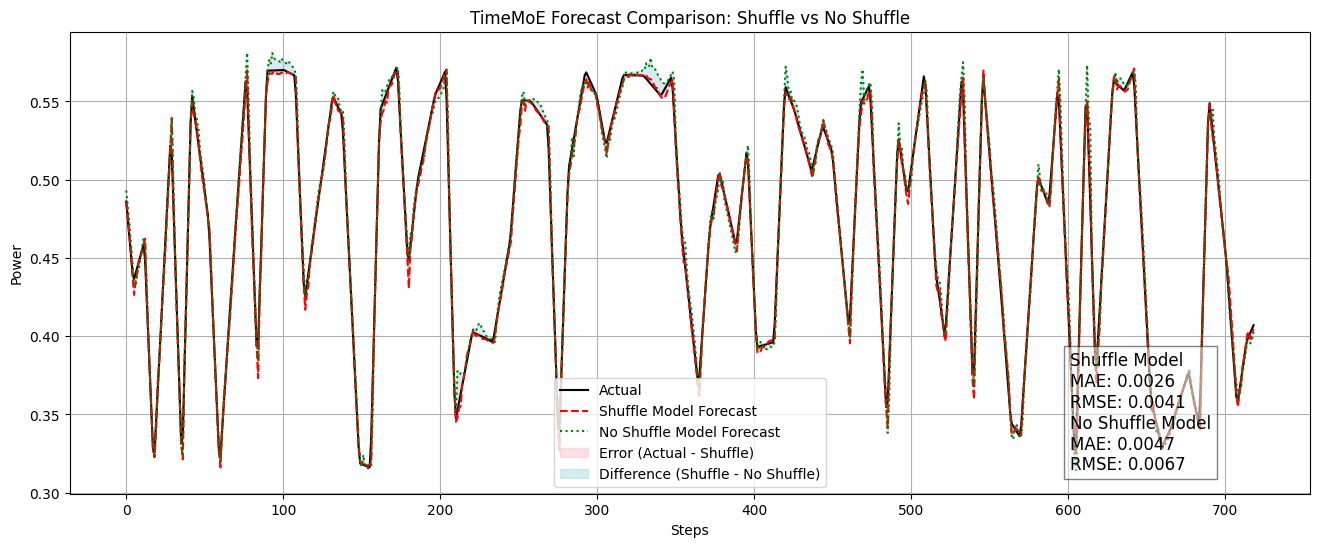

Shuffle Model - MSE: 0.0000, MAE: 0.0018, RMSE: 0.0029
No Shuffle Model - MSE: 0.0000, MAE: 0.0040, RMSE: 0.0061


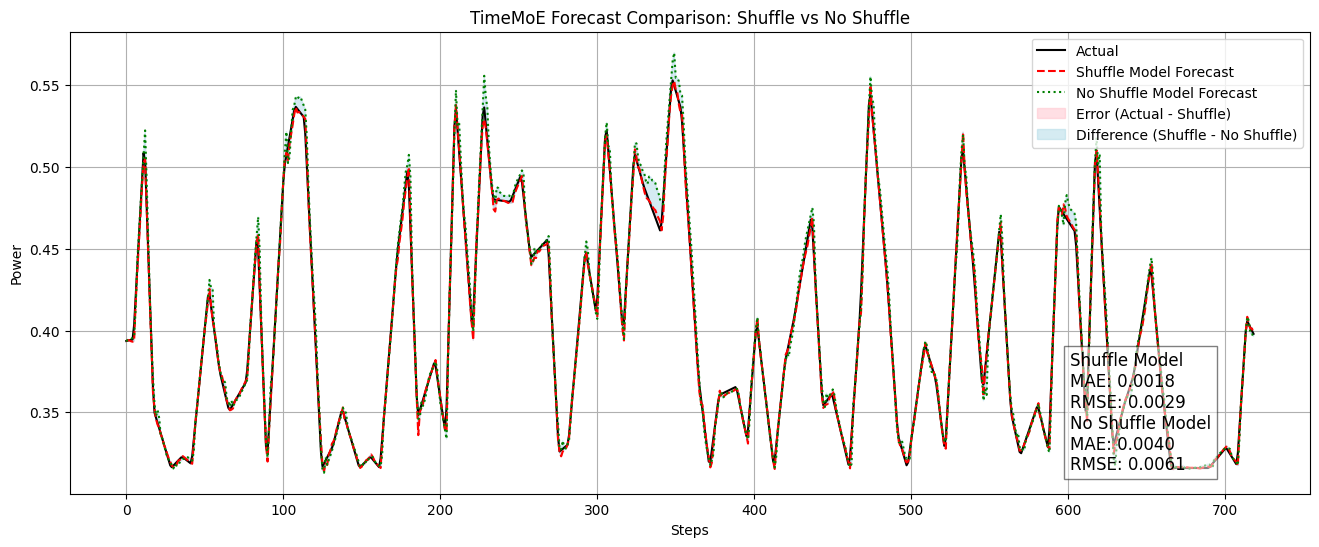

In [24]:
print("\nEvaluating PatchTST on test data...")
evaluate_two_timemoe_models(model_orig=model_TimeMOE_org,model_aug=model_TimeMOE_no_shuffle, scaler= scaler_TimeMOE_aug, X_test=X_test, y_test= y_test,y_train_org=y_train_org,features= features, seq_len=seq_len, start_point=7991, end_point=8734)
evaluate_two_timemoe_models(model_orig=model_TimeMOE_org,model_aug= model_TimeMOE_no_shuffle, scaler= scaler_TimeMOE_aug,X_test= X_test,y_test= y_test,y_train_org=y_train_org,features= features, seq_len=seq_len,  start_point=16726, end_point=17469)
evaluate_two_timemoe_models(model_orig=model_TimeMOE_org,model_aug= model_TimeMOE_no_shuffle, scaler= scaler_TimeMOE_aug, X_test=X_test,y_test= y_test,y_train_org=y_train_org,features= features,seq_len= seq_len,  start_point=25461, end_point=26204)
evaluate_two_timemoe_models(model_orig=model_TimeMOE_org,model_aug= model_TimeMOE_no_shuffle, scaler= scaler_TimeMOE_aug, X_test=X_test,y_test= y_test,y_train_org=y_train_org,features= features,seq_len= seq_len,  start_point=34196, end_point=34939)


In [27]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math 

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100


def evaluate_monthly_timemoe_errors(
    model_orig, model_aug, 
    scaler_X, y_train_org,
    X_test, y_test, features,
    seq_len
):
    # Prepare index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale full test set
    X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=features)

    # Inverse scaler for target
    y_scaler = StandardScaler().fit(y_train_org.values.reshape(-1, 1))

    # Location slicing
    total_len = len(X_test)
    n_locations = 4
    loc_size = total_len // n_locations

    results = []

    for loc in range(n_locations):
        start_idx = loc * loc_size
        end_idx = (loc + 1) * loc_size

        # Data for this location
        X_loc = X_test_scaled.iloc[start_idx:end_idx]
        y_loc = y_test.iloc[start_idx:end_idx]

        for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
            y_month = y_loc[df_month.index]

            if len(df_month) < seq_len + 1:
                continue

            # Create sequences
            X_seq, y_seq = create_autoregressive_sequences(df_month[features],y_month, seq_len)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            # Predict
            with torch.no_grad():
                model_orig.eval()
                model_aug.eval()
                preds_orig = model_orig(X_tensor).numpy()
                preds_aug = model_aug(X_tensor).numpy()

            # Inverse transform
            y_true = y_scaler.inverse_transform(y_seq.reshape(-1, 1)).flatten()
            preds_orig_inv = y_scaler.inverse_transform(preds_orig.reshape(-1, 1)).flatten()
            preds_aug_inv = y_scaler.inverse_transform(preds_aug.reshape(-1, 1)).flatten()

            # Compute metrics
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_shuffle': mean_absolute_error(y_true, preds_orig_inv),
                'rmse_shuffle': math.sqrt(mean_squared_error(y_true, preds_orig_inv)),
                'mape_shuffle': mape(y_true, preds_orig_inv),
                'smape_shuffle': smape(y_true, preds_orig_inv),
                'r2_shuffle': r2_score(y_true, preds_orig_inv),
                'mae_no_shuffle': mean_absolute_error(y_true, preds_aug_inv),
                'rmse_no_shuffle': math.sqrt(mean_squared_error(y_true, preds_aug_inv)),
                'mape_no_shuffle': mape(y_true, preds_aug_inv),
                'smape_no_shuffle': smape(y_true, preds_aug_inv),
                'r2_no_shuffle': r2_score(y_true, preds_aug_inv)
            })

    results_df = pd.DataFrame(results)

    # Monthly average + std across 4 locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_shuffle': ['mean', 'std'],
        'rmse_shuffle': ['mean', 'std'],
        'mape_shuffle': ['mean', 'std'],
        'smape_shuffle': ['mean', 'std'],
        'r2_shuffle': ['mean', 'std'],
        'mae_no_shuffle': ['mean', 'std'],
        'rmse_no_shuffle': ['mean', 'std'],
        'mape_no_shuffle': ['mean', 'std'],
        'smape_no_shuffle': ['mean', 'std'],
        'r2_no_shuffle': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]

    return results_df, monthly_summary


In [28]:
results_df, monthly_summary = evaluate_monthly_timemoe_errors(
    model_orig=model_TimeMOE_org,
    model_aug=model_TimeMOE_no_shuffle,
    scaler_X=scaler_TimeMOE_aug,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    features=features,
    seq_len=seq_len
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7693/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7693/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7693/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_7693/3678095457.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in X_loc.groupby(pd.Grouper(freq='M')):


In [29]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_shuffle': f"{loc_data['mae_shuffle'].mean():.4f}  ± {loc_data['mae_shuffle'].std():.4f}",
        'rmse_shuffle': f"{loc_data['rmse_shuffle'].mean():.4f}  ± {loc_data['rmse_shuffle'].std():.4f}",
        'mape_shuffle': f"{loc_data['mape_shuffle'].mean():.4f}  ± {loc_data['mape_shuffle'].std():.4f}",
        'smape_shuffle': f"{loc_data['smape_shuffle'].mean():.4f}  ± {loc_data['smape_shuffle'].std():.4f}",
        'r2_shuffle': f"{loc_data['r2_shuffle'].mean():.4f}  ± {loc_data['r2_shuffle'].std():.4f}",
        'mae_no_shuffle': f"{loc_data['mae_no_shuffle'].mean():.4f}  ± {loc_data['mae_no_shuffle'].std():.4f}",
        'rmse_no_shuffle': f"{loc_data['rmse_no_shuffle'].mean():.4f}  ± {loc_data['rmse_no_shuffle'].std():.4f}",
        'mape_no_shuffle': f"{loc_data['mape_no_shuffle'].mean():.4f}  ± {loc_data['mape_no_shuffle'].std():.4f}",
        'smape_no_shuffle': f"{loc_data['smape_no_shuffle'].mean():.4f}  ± {loc_data['smape_no_shuffle'].std():.4f}",
        'r2_no_shuffle': f"{loc_data['r2_no_shuffle'].mean():.4f}  ± {loc_data['r2_no_shuffle'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_shuffle': f"{results_df['mae_shuffle'].mean():.4f}  ± {results_df['mae_shuffle'].std():.4f}",
    'rmse_shuffle': f"{results_df['rmse_shuffle'].mean():.4f}  ± {results_df['rmse_shuffle'].std():.4f}",
    'mape_shuffle': f"{results_df['mape_shuffle'].mean():.4f}  ± {results_df['mape_shuffle'].std():.4f}",
    'smape_shuffle': f"{results_df['smape_shuffle'].mean():.4f}  ± {results_df['smape_shuffle'].std():.4f}",
    'r2_shuffle': f"{results_df['r2_shuffle'].mean():.4f}  ± {results_df['r2_shuffle'].std():.4f}",
    'mae_no_shuffle': f"{results_df['mae_no_shuffle'].mean():.4f}  ± {results_df['mae_no_shuffle'].std():.4f}",
    'rmse_no_shuffle': f"{results_df['rmse_no_shuffle'].mean():.4f}  ± {results_df['rmse_no_shuffle'].std():.4f}",
    'mape_no_shuffle': f"{results_df['mape_no_shuffle'].mean():.4f}  ± {results_df['mape_no_shuffle'].std():.4f}",
    'smape_no_shuffle': f"{results_df['smape_no_shuffle'].mean():.4f}  ± {results_df['smape_no_shuffle'].std():.4f}",
    'r2_no_shuffle': f"{results_df['r2_no_shuffle'].mean():.4f}  ± {results_df['r2_no_shuffle'].std():.4f}",
})
final_results =  pd.DataFrame(final_results)

In [30]:
final_results

,Location,mae_shuffle,rmse_shuffle,mape_shuffle,smape_shuffle,r2_shuffle,mae_no_shuffle,rmse_no_shuffle,mape_no_shuffle,smape_no_shuffle,r2_no_shuffle
0,Location_1,0.0015 ± 0.0003,0.0024 ± 0.0004,0.3496 ± 0.0524,0.3503 ± 0.0527,0.9988 ± 0.0002,0.0026 ± 0.0006,0.0038 ± 0.0008,0.6025 ± 0.1075,0.6027 ± 0.1070,0.9970 ± 0.0011
1,Location_2,0.0013 ± 0.0003,0.0021 ± 0.0006,0.3492 ± 0.0791,0.3496 ± 0.0795,0.9975 ± 0.0005,0.0028 ± 0.0008,0.0043 ± 0.0011,0.7290 ± 0.1747,0.7253 ± 0.1730,0.9896 ± 0.0031
2,Location_3,0.0014 ± 0.0007,0.0023 ± 0.0011,0.3624 ± 0.1229,0.3630 ± 0.1236,0.9964 ± 0.0031,0.0026 ± 0.0010,0.0039 ± 0.0015,0.6757 ± 0.1856,0.6734 ± 0.1848,0.9871 ± 0.0163
3,Location_4,0.0013 ± 0.0003,0.0021 ± 0.0004,0.3272 ± 0.0619,0.3276 ± 0.0622,0.9984 ± 0.0005,0.0025 ± 0.0007,0.0038 ± 0.0011,0.6335 ± 0.1469,0.6314 ± 0.1458,0.9946 ± 0.0018
4,All Location Combined,0.0014 ± 0.0004,0.0022 ± 0.0007,0.3471 ± 0.0819,0.3476 ± 0.0823,0.9978 ± 0.0018,0.0026 ± 0.0008,0.0039 ± 0.0012,0.6602 ± 0.1589,0.6582 ± 0.1575,0.9921 ± 0.0090


In [31]:
monthly_summary

,month,mae_shuffle_mean,mae_shuffle_std,rmse_shuffle_mean,rmse_shuffle_std,mape_shuffle_mean,mape_shuffle_std,smape_shuffle_mean,smape_shuffle_std,r2_shuffle_mean,...,mae_no_shuffle_mean,mae_no_shuffle_std,rmse_no_shuffle_mean,rmse_no_shuffle_std,mape_no_shuffle_mean,mape_no_shuffle_std,smape_no_shuffle_mean,smape_no_shuffle_std,r2_no_shuffle_mean,r2_no_shuffle_std
0,2021-01,0.001291,0.000272,0.002160,0.000472,0.329256,0.060806,0.329629,0.060928,0.998164,...,0.002482,0.000305,0.003768,0.000528,0.652131,0.108287,0.649350,0.106488,0.992665,0.006740
1,2021-02,0.001277,0.000237,0.002102,0.000447,0.325481,0.040075,0.325964,0.040542,0.998036,...,0.002533,0.000267,0.003838,0.000468,0.660337,0.096002,0.657695,0.094156,0.992487,0.004686
2,2021-03,0.001515,0.000441,0.002383,0.000596,0.373643,0.062006,0.374402,0.062548,0.998122,...,0.002947,0.000460,0.004386,0.000721,0.735378,0.053820,0.732780,0.052315,0.993068,0.003460
3,2021-04,0.001431,0.000138,0.002363,0.000173,0.366765,0.013716,0.367562,0.013616,0.997771,...,0.002778,0.000238,0.004160,0.000380,0.710167,0.017219,0.709119,0.017230,0.993064,0.002457
4,2021-05,0.001188,0.000177,0.001908,0.000346,0.311825,0.027643,0.312178,0.027790,0.997941,...,0.002210,0.000387,0.003334,0.000830,0.584642,0.086045,0.583359,0.085290,0.993581,0.003875
5,2021-06,0.001087,0.000236,0.001736,0.000433,0.290879,0.032920,0.291079,0.033298,0.997822,...,0.001973,0.000294,0.003058,0.000502,0.529364,0.038181,0.528549,0.038481,0.992471,0.006623
6,2021-07,0.000870,0.000289,0.001404,0.000524,0.238525,0.064263,0.238611,0.064437,0.995464,...,0.001661,0.000436,0.002473,0.000733,0.455841,0.082117,0.455353,0.082729,0.980398,0.029097
7,2021-08,0.001035,0.000236,0.001663,0.000448,0.283590,0.057036,0.283701,0.057319,0.998006,...,0.001864,0.000404,0.002888,0.000745,0.510312,0.096916,0.509169,0.095560,0.993673,0.002828
8,2021-09,0.001380,0.000234,0.002275,0.000305,0.347902,0.046090,0.348359,0.046249,0.998226,...,0.002527,0.000368,0.003849,0.000561,0.646179,0.108033,0.644337,0.106447,0.994575,0.003046
9,2021-10,0.001535,0.000359,0.002516,0.000594,0.372998,0.071090,0.373787,0.071440,0.998540,...,0.002749,0.000492,0.004221,0.000872,0.668103,0.109076,0.666268,0.107306,0.995418,0.003151


In [32]:
FOLDER_NAME = './Results/TimeMOE'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)